# **Movie Recommender System**

Data Cleaning/Preperation

Project team members:
- Nicholas Bray
- Emma Stefanovich
- April Uzzle

# Setup

In [3]:
# Run if you don't have pycountry installed already
#import sys
#!{sys.executable} -m pip install pycountry

In [4]:
import pandas as pd
import numpy as np
import json
import re
from datetime import datetime
import pycountry
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from collections import Counter

np.random.seed(123)

In [5]:
# Read CSV file, treating "", " ", and "NA" as missing values
movies = pd.read_csv("tmdb_5000_movies.csv", na_values = ["", " ", "NA"])
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

# Data Description

This dataset is called [TMDB 5000 Movie Dataset](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata). It contains information on movies from [The Movie Database.](https://www.themoviedb.org/?language=en-US) It has 4,803 observations. It has data on movies released from 1916 to 2016.

It contains the following variables:

- *budget*: The budget of the movie's production, in USD.
- *genres*: A list of genres applicable to the movie.
- *homepage*: The movie's website, if it has one.
- *id*: The movie's ID number in The Movie Database.
- *keywords*: The list of keywords associated with the movie in The Movie Database.
- *original_language*: The original language the movie was produced in, given in ISO 639-1 code format.
- *original_title*: The original name the movie was released with.
- *overview*: The description of the move in The Movie Database.
- *popularity*: The current popularity score of the movie in The Movie Database, determined by the average number of users searching for the movie per day.
- *production_companies*: A list of production companies that created the movie.
- *production_countries*: A list of countries the movie was produced in.
- *release_date*: The date on which the movie was first released.
- *revenue*: The total earnings of the movie, in USD.
- *runtime*: The length of the movie in minutes.
- *spoken_languages*: The language(s) that the movie is currently available in.
- *status*: If the movie has been released, rumored to be released soon, or is in post-production.
- *tagline*: The tagline of the movie in The Movie Database.
- *title*: The current title of the movie.
- *vote_average*: The average user review score of the movie in The Movie Database.
- *vote_count*: The number of users who reviewed and scored the movie.

Not all of these variables are useful for analysis. We will be excluding the following variables from any analyses:

- *homepage* (website url, unnecessary text)
- *id* (unnecessary id column)
- *original_language* (unnecessary information, will use spoken_languages instead)
- *overview* (unnecessary text)
- *status* (unnecessary information)
- *tagline* (unnecessary text)
- *title* (unnecessary text)

In [7]:
movies = movies.drop(columns = ["homepage", "id", "original_language", "overview", "status", "tagline", "title"])

# Data Cleaning

## Overview

We'll start by looking at what the data looks like, seeing if there are any issues we can fix, and looking for missing values.

In [9]:
movies.head(5)

,budget,genres,keywords,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",Avatar,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",Pirates of the Caribbean: At World's End,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",Spectre,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",The Dark Knight Rises,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",John Carter,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",6.1,2124


In [10]:
movies.dtypes

budget                    int64
genres                   object
keywords                 object
original_title           object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
vote_average            float64
vote_count                int64
dtype: object

## JSON Columns

Some columns are in JSON format, and are not usable in this state. We can extract the necessary values from them with the json library.

The following columns need fixing:

- *genres*
- *production_companies*
- *production_countries*
- *spoken_languages*

For *production_countries* and *spoken_languages*, the JSON contains both the name of the country/language and the ISO code of the country/language. We will extract both, and create new columns for the ISO codes.

In [12]:
# Helper function to parse JSON columns
def extract_from_json(json_str, key):
    """
    Parse a JSON string (expected to be a list of dicts) and extract the values
    associated with the specified key, returning a comma-separated string
    """
    if pd.isnull(json_str):
        return np.nan
    try:
        data = json.loads(json_str)
        if isinstance(data, list):
            # Filter out empty strings and join values with a comma
            values = [str(item.get(key, '')) for item in data if item.get(key, '')]
            return ", ".join(values) if values else np.nan
    except Exception as e:
        return np.nan

In [13]:
# Process JSON columns
# --------------------------
# genres: extract name
movies['genres'] = movies['genres'].apply(lambda x: extract_from_json(x, 'name'))

# keywords: extract name
movies['keywords'] = movies['keywords'].apply(lambda x: extract_from_json(x, 'name'))

# production companies: extract name
movies['production_companies'] = movies['production_companies'].apply(lambda x: extract_from_json(x, 'name'))

# production countries: extract both ISO codes and names
movies['production_ISO'] = movies['production_countries'].apply(lambda x: extract_from_json(x, 'iso_3166_1'))
movies['production_countries'] = movies['production_countries'].apply(lambda x: extract_from_json(x, 'name'))

# spoken languages: extract both ISO codes and names
movies['spoken_ISO'] = movies['spoken_languages'].apply(lambda x: extract_from_json(x, 'iso_639_1'))
movies['spoken_languages'] = movies['spoken_languages'].apply(lambda x: extract_from_json(x, 'name'))

# Check data types to ensure correct data was retreived
print("Data type for genres column:", movies['genres'].apply(type).unique())
print("Data type for production_companies column:", movies['production_companies'].apply(type).unique())
print("Data type for production_ISO column:", movies['production_ISO'].apply(type).unique())
print("Data type for spoken_languages column:", movies['spoken_languages'].apply(type).unique())
print("Data type for spoken_ISO column:", movies['spoken_ISO'].apply(type).unique())

Data type for genres column: [<class 'str'> <class 'float'>]
Data type for production_companies column: [<class 'str'> <class 'float'>]
Data type for production_ISO column: [<class 'str'> <class 'float'>]
Data type for spoken_languages column: [<class 'str'> <class 'float'>]
Data type for spoken_ISO column: [<class 'str'> <class 'float'>]


In [14]:
movies.head(5)

,budget,genres,keywords,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,production_ISO,spoken_ISO
0,237000000,"Action, Adventure, Fantasy, Science Fiction","culture clash, future, space war, space colony...",Avatar,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,"English, Español",7.2,11800,"US, GB","en, es"
1,300000000,"Adventure, Fantasy, Action","ocean, drug abuse, exotic island, east india t...",Pirates of the Caribbean: At World's End,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,English,6.9,4500,US,en
2,245000000,"Action, Adventure, Crime","spy, based on novel, secret agent, sequel, mi6...",Spectre,107.376788,"Columbia Pictures, Danjaq, B24","United Kingdom, United States of America",2015-10-26,880674609,148.0,"Français, English, Español, Italiano, Deutsch",6.3,4466,"GB, US","fr, en, es, it, de"
3,250000000,"Action, Crime, Drama, Thriller","dc comics, crime fighter, terrorist, secret id...",The Dark Knight Rises,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",United States of America,2012-07-16,1084939099,165.0,English,7.6,9106,US,en
4,260000000,"Action, Adventure, Science Fiction","based on novel, mars, medallion, space travel,...",John Carter,43.926995,Walt Disney Pictures,United States of America,2012-03-07,284139100,132.0,English,6.1,2124,US,en


## Categorical Column Values

Next, let's see if there are any issues with the categorical variables, such as misspelled, duplicate, or generally unexpected categories. We will not look at the individual distinct *keywords* or *production_companies* because there would be too many distinct values to examine, but we will still get a count of distinct values.

In [16]:
def get_unique_values(series):
    unique_vals = set()
    series.dropna().str.split(", ").apply(unique_vals.update)
    return unique_vals

unique_genres = get_unique_values(movies['genres'])
print("--- Unique genres ---")
print(unique_genres)
print("Total unique genres:", len(unique_genres), "\n")

unique_keywords = get_unique_values(movies['keywords'])
print("--- Number of unique keywords ---")
print(len(unique_keywords), "\n")

unique_prod_companies = get_unique_values(movies['production_companies'])
print("--- Number of unique production companies ---")
print(len(unique_prod_companies), "\n")

unique_prod_countries = get_unique_values(movies['production_countries'])
print("--- Unique production countries ---")
print(unique_prod_countries)
print("Total unique production countries:", len(unique_prod_countries), "\n")

unique_prod_ISO = get_unique_values(movies['production_ISO'])
print("--- Unique production countries ISO codes ---")
print(unique_prod_ISO)
print("Total unique production countries ISO codes:", len(unique_prod_ISO), "\n")

unique_spoken_languages = get_unique_values(movies['spoken_languages'])
print("--- Unique spoken languages ---")
print(unique_spoken_languages)
print("Total unique spoken languages:", len(unique_spoken_languages), "\n")

unique_spoken_ISO = get_unique_values(movies['spoken_ISO'])
print("--- Unique spoken language ISO codes ---")
print(unique_spoken_ISO)
print("Total unique spoken language ISO codes:", len(unique_spoken_ISO), "\n")

--- Unique genres ---
{'Adventure', 'TV Movie', 'Horror', 'Family', 'History', 'Mystery', 'Drama', 'Western', 'Fantasy', 'War', 'Music', 'Foreign', 'Animation', 'Science Fiction', 'Thriller', 'Romance', 'Crime', 'Documentary', 'Comedy', 'Action'}
Total unique genres: 20 

--- Number of unique keywords ---
9814 

--- Number of unique production companies ---
5025 

--- Unique production countries ---
{'Chile', 'Sweden', 'Hong Kong', 'Kyrgyz Republic', 'Colombia', 'Denmark', 'China', 'Dominican Republic', 'Tunisia', 'Libyan Arab Jamahiriya', 'Russia', 'India', 'Lithuania', 'Aruba', 'Canada', 'Norway', 'Egypt', 'Luxembourg', 'Taiwan', 'Hungary', 'United States of America', 'Guadaloupe', 'Afghanistan', 'Romania', 'Bolivia', 'Japan', 'Jordan', 'Germany', 'Slovakia', 'Malaysia', 'Morocco', 'Ukraine', 'Thailand', 'Bhutan', 'Poland', 'Brazil', 'France', 'Peru', 'Argentina', 'Algeria', 'Portugal', 'Mexico', 'Spain', 'Turkey', 'South Africa', 'United Arab Emirates', 'Serbia and Montenegro', 'Fij

- *genres*: There is nothing unexpected here. Each genre is listed only once, with no misspellings or duplicates. There are 20 unique genres.
- *keywords*: There are 9,814 unique keywords.
- *production_companies*: There are 5,025 unique production companies.
- *production_countries*: There seem to be some country names that are unexpected. For example, Serbia is listed twice - once as "Serbia" and again as "Serbia and Montenegro". Regardless, there are 88 unique country names.
- *production_ISO*: There is nothing unexpected here. Each country ISO is listed only once, with no misspellings or duplicates. There are 88 unique country ISO codes, which matches the previous 88 unique country names.
- *spoken_languages*: There seem to be some invalid language names here. For example, there is a blank ("") language, question marks ("??????"), and "No Language". We will consider turning these entries into null values depending on how many there are.
- *spoken_ISO*: There seem to be some invalid language codes here, like "xx". Regardless, there are 87 unique spoken language ISO codes.

We will be using the ISO code variables from now on, for the sake of simplicity and reliability. The ISO code variables have far fewer issues than the variables that use language and country names.

In [18]:
# Get valid ISO 3166-1 country codes from pycountry
valid_country_codes = {country.alpha_2 for country in pycountry.countries}

# Get valid ISO 639-1 language codes from pycountry.
# Note: pycountry.languages may include entries without an alpha_2 attribute, so we filter on length
valid_language_codes = {lang.alpha_2 for lang in pycountry.languages if hasattr(lang, 'alpha_2') and len(lang.alpha_2) == 2}

# Function to get unique codes from a column (split by comma and space)
def get_unique_codes(series):
    codes = set()
    series.dropna().str.split(", ").apply(codes.update)
    return codes

unique_spoken_ISO = get_unique_codes(movies['spoken_ISO'])
unique_prod_ISO = get_unique_codes(movies['production_ISO'])

invalid_spoken = unique_spoken_ISO - valid_language_codes
invalid_prod = unique_prod_ISO - valid_country_codes

print("Invalid spoken language ISO codes:", invalid_spoken)
print("Invalid production country ISO codes:", invalid_prod)

Invalid spoken language ISO codes: {'xx', 'cn'}
Invalid production country ISO codes: {'CS'}


From these results, we can see that there are 2 invalid language codes in spoken_languages (cn, xx) and 1 invalid country code in production_countries (CS).

Upon searching for these language codes online, it appears that:

- "cn" is likely supposed to be for Chinese (whose real code is "zh"), considering "CN" is the valid country code for China
- "xx" is a unique identifier for when a movie has no language or subtitles
- "CS" is the old unique identifier for Serbia and Montenegro

From these results, we will add "CS" to the list of valid countries, as it used to be a valid code and is likely present from older movies. "xx" deliberately denotes movies with no language, which is not an error with the data. We will not add "cn" as there is no evidence that this code was ever a valid code, and is likely an error in the data. However, we will fix the data to replace all instances of "cn" in language variables with "zh".

In [20]:
# Update valid language and country codes
valid_language_codes.update(["xx"])
valid_country_codes.update(["CS"])

# Replace "cn" with "zh" (Chinese) in the spoken_ISO column
movies['spoken_ISO'] = movies['spoken_ISO'].str.replace(r'\bcn\b', 'zh', regex = True)

unique_spoken_ISO = get_unique_codes(movies['spoken_ISO'])
unique_prod_ISO = get_unique_codes(movies['production_ISO'])

invalid_spoken = unique_spoken_ISO - valid_language_codes
invalid_prod = unique_prod_ISO - valid_country_codes

print("Invalid spoken language ISO codes:", invalid_spoken)
print("Invalid production country ISO codes:", invalid_prod)

Invalid spoken language ISO codes: set()
Invalid production country ISO codes: set()


In [21]:
# Drop the name-based columns, as we will use the ISO columns
movies = movies.drop(columns = ['production_countries', 'spoken_languages'])

In [22]:
movies.head(5)

,budget,genres,keywords,original_title,popularity,production_companies,release_date,revenue,runtime,vote_average,vote_count,production_ISO,spoken_ISO
0,237000000,"Action, Adventure, Fantasy, Science Fiction","culture clash, future, space war, space colony...",Avatar,150.437577,"Ingenious Film Partners, Twentieth Century Fox...",2009-12-10,2787965087,162.0,7.2,11800,"US, GB","en, es"
1,300000000,"Adventure, Fantasy, Action","ocean, drug abuse, exotic island, east india t...",Pirates of the Caribbean: At World's End,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",2007-05-19,961000000,169.0,6.9,4500,US,en
2,245000000,"Action, Adventure, Crime","spy, based on novel, secret agent, sequel, mi6...",Spectre,107.376788,"Columbia Pictures, Danjaq, B24",2015-10-26,880674609,148.0,6.3,4466,"GB, US","fr, en, es, it, de"
3,250000000,"Action, Crime, Drama, Thriller","dc comics, crime fighter, terrorist, secret id...",The Dark Knight Rises,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",2012-07-16,1084939099,165.0,7.6,9106,US,en
4,260000000,"Action, Adventure, Science Fiction","based on novel, mars, medallion, space travel,...",John Carter,43.926995,Walt Disney Pictures,2012-03-07,284139100,132.0,6.1,2124,US,en


## Release Date

Next, let's examine *release_date*. We will coerce it to date data type and make sure there are no unexpected values. We will also create individual *release_year*, *release_month*, and *release_day* columns.

In [24]:
# Convert release_date to datetime
movies['release_date'] = pd.to_datetime(movies['release_date'], errors = 'coerce')

# Create release_year and release_month columns
movies['release_year'] = movies['release_date'].dt.year
movies['release_month'] = movies['release_date'].dt.month
movies['release_day'] = movies['release_date'].dt.day

In [25]:
print(movies['release_date'].describe())

print(min(movies['release_date']))
print(max(movies['release_date']))

print((movies['release_year'] == 2017).sum())

count                             4802
mean     2002-12-27 23:45:54.352353280
min                1916-09-04 00:00:00
25%                1999-07-14 00:00:00
50%                2005-10-03 00:00:00
75%                2011-02-16 00:00:00
max                2017-02-03 00:00:00
Name: release_date, dtype: object
1916-09-04 00:00:00
2017-02-03 00:00:00
1


It also seems that although the data description says that it ranges from 1916 to 2016, there is one row for a movie that was scheduled to release in 2017. We will remove it.

In [27]:
movies = movies[movies['release_year'] != 2017]

## Null Values

Finally, we should look for any null values to see if any variables are missing a substantial amount of data. We should turn any blank values in the dataset into null values for consistency. Additionally, we will turn revenues and vote_averages of 0 into null values, as a zero for either of these columns means there is no data available.

In [29]:
# Ensure any remaining blank strings are replaced with NA
movies.replace("", np.nan, inplace = True)

# Replace 0 values with NA for 'revenue' and 'vote_average'
movies['revenue'] = movies['revenue'].replace(0, np.nan)
movies['vote_average'] = movies['vote_average'].replace(0, np.nan)

# Print the number of null values per column
print("Null values per column:")
print(movies.isnull().sum())

Null values per column:
budget                     0
genres                    28
keywords                 411
original_title             0
popularity                 0
production_companies     350
release_date               1
revenue                 1426
runtime                    2
vote_average              63
vote_count                 0
production_ISO           173
spoken_ISO                86
release_year               1
release_month              1
release_day                1
dtype: int64


There are null values in:

- *genres* (28)
- *keywords* (411)
- *production_companies* (350)
- *release_date* (1)
- *revenue* (1,426)
- *runtime* (2)
- *vote_average* (63)
- *production_ISO* (173)
- *spoken_ISO* (86)
- *release_year* (1)
- *release_month* (1)
- *release_day* (1)

The only variable with a non-negligible amount of missing data is *revenue*, which is missing 1,426 rows.

In [31]:
movies.head()

,budget,genres,keywords,original_title,popularity,production_companies,release_date,revenue,runtime,vote_average,vote_count,production_ISO,spoken_ISO,release_year,release_month,release_day
0,237000000,"Action, Adventure, Fantasy, Science Fiction","culture clash, future, space war, space colony...",Avatar,150.437577,"Ingenious Film Partners, Twentieth Century Fox...",2009-12-10,2.787965e+09,162.0,7.2,11800,"US, GB","en, es",2009.0,12.0,10.0
1,300000000,"Adventure, Fantasy, Action","ocean, drug abuse, exotic island, east india t...",Pirates of the Caribbean: At World's End,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",2007-05-19,9.610000e+08,169.0,6.9,4500,US,en,2007.0,5.0,19.0
2,245000000,"Action, Adventure, Crime","spy, based on novel, secret agent, sequel, mi6...",Spectre,107.376788,"Columbia Pictures, Danjaq, B24",2015-10-26,8.806746e+08,148.0,6.3,4466,"GB, US","fr, en, es, it, de",2015.0,10.0,26.0
3,250000000,"Action, Crime, Drama, Thriller","dc comics, crime fighter, terrorist, secret id...",The Dark Knight Rises,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",2012-07-16,1.084939e+09,165.0,7.6,9106,US,en,2012.0,7.0,16.0
4,260000000,"Action, Adventure, Science Fiction","based on novel, mars, medallion, space travel,...",John Carter,43.926995,Walt Disney Pictures,2012-03-07,2.841391e+08,132.0,6.1,2124,US,en,2012.0,3.0,7.0


## Imputation of *revenue*

Let's try to use scikit-learn's IterativeImputer to fill in *revenue*'s missing values.

In [33]:
# Check distribution of revenue first
movies['revenue'].describe()

count    3.376000e+03
mean     1.170314e+08
std      1.834831e+08
min      5.000000e+00
25%      1.535290e+07
50%      5.175184e+07
75%      1.401651e+08
max      2.787965e+09
Name: revenue, dtype: float64

In [34]:
# Set of predictors that are likely related to revenue
features = [
    'budget',
    'popularity',
    'runtime',
    'vote_average',
    'vote_count',
    'release_year',
    'release_month',
    'release_day',
    'revenue'
]

# Create a working DataFrame with the selected features
df_imp = movies[features].copy()

# Distribution of revenue is skewed, so use a log transformation first
df_imp['log_revenue'] = np.log(df_imp['revenue'])

# Check the number of missing revenue values before imputation
print("Missing revenue before imputation:", df_imp['revenue'].isnull().sum())

Missing revenue before imputation: 1426


In [35]:
# Set up imputer
imputer = IterativeImputer(
    estimator = RandomForestRegressor(n_estimators = 100, random_state = 42),
    random_state = 42
)

# Fit the imputer and transform the data (this will take a little time to run)
imputed_array = imputer.fit_transform(df_imp)

In [36]:
# Convert the result back into a DataFrame
df_imputed = pd.DataFrame(imputed_array, columns = df_imp.columns)

print("Missing revenue after imputation:", df_imputed['revenue'].isnull().sum())

Missing revenue after imputation: 0


In [37]:
# Copy imputed revenue results to original movies df
movies['revenue_imputed'] = df_imputed['revenue']

In [38]:
movies[movies[('revenue')].isna()].head(10)

,budget,genres,keywords,original_title,popularity,production_companies,release_date,revenue,runtime,vote_average,vote_count,production_ISO,spoken_ISO,release_year,release_month,release_day,revenue_imputed
83,27000000,"Action, Adventure, Science Fiction, Romance",NaN,The Lovers,2.418535,"Corsan, Bliss Media, Limelight International M...",2015-02-13,NaN,109.0,4.8,34,"AU, BE, IN",en,2015.0,2.0,13.0,35530885.91
135,150000000,"Drama, Horror, Thriller","father son relationship, victorian england, re...",The Wolfman,21.214571,"Universal Pictures, Stuber Productions, Relati...",2010-02-11,NaN,102.0,5.5,549,US,en,2010.0,2.0,11.0,35449072.02
265,0,"Comedy, Fantasy, Family","cat, brother sister relationship, boredom, cha...",The Cat in the Hat,18.251129,"Imagine Entertainment, DreamWorks SKG, Univers...",2003-11-21,NaN,82.0,4.9,366,US,en,2003.0,11.0,21.0,35535133.73
309,84000000,"Fantasy, Comedy, Family, Adventure","baby, mask, viking",Son of the Mask,17.815595,"New Line Cinema, Pathé Distribution",2005-02-18,NaN,94.0,3.6,338,"DE, US",en,2005.0,2.0,18.0,35526453.38
376,90000000,"Science Fiction, Action, Drama, Thriller","subway, lava, volcano, volcanologist, los angeles",Volcano,19.836124,Twentieth Century Fox Film Corporation,1997-04-25,NaN,104.0,5.2,376,US,"de, es, en",1997.0,4.0,25.0,35449585.06
406,0,"Drama, Animation, Family, Comedy","holiday, santa claus, duringcreditsstinger, wo...",Arthur Christmas,19.836830,"Columbia Pictures, Aardman Animations, Sony Pi...",2011-02-22,NaN,97.0,6.7,333,US,en,2011.0,2.0,22.0,35532450.11
433,84000000,"Action, Comedy, Crime, Thriller","paris, london england, cia, russia, mi6, hired...",RED 2,44.343330,"DC Comics, Di Bonaventura Pictures, Summit Ent...",2013-07-18,NaN,116.0,6.4,1526,"CA, FR, US","en, fr, ru",2013.0,7.0,18.0,35525741.73
453,0,"Action, Comedy, Crime, Mystery, Family","robbery, investigation, inspector, killer, clo...",The Pink Panther,25.450534,"Columbia Pictures, International Production Co...",2006-01-18,NaN,93.0,5.6,550,US,en,2006.0,1.0,18.0,35527667.32
463,0,"Romance, Drama","love, american, pin, stranger, ruby",Déjà Vu,0.605645,"Rainbow Film Company, The, Revere Entertainmen...",1998-04-22,NaN,117.0,8.0,1,US,en,1998.0,4.0,22.0,35544114.75
467,90000000,"Action, Adventure, Family, Fantasy","gorilla, dying and death",Mighty Joe Young,6.643778,"Walt Disney Pictures, RKO Pictures",1998-12-25,NaN,114.0,5.9,208,US,"sw, en",1998.0,12.0,25.0,35531760.78


# Data Exploration

Now that the data is fully cleaned, let's do some exploration and visualization to get a deeper understanding of our data.

## Numeric Variables

In [41]:
print(movies.describe())

             budget   popularity                   release_date       revenue  \
count  4.802000e+03  4802.000000                           4801  3.376000e+03   
mean   2.905109e+07    21.496628  2002-12-26 22:00:55.488440192  1.170314e+08   
min    0.000000e+00     0.000000            1916-09-04 00:00:00  5.000000e+00   
25%    8.000000e+05     4.671734            1999-07-14 00:00:00  1.535290e+07   
50%    1.500000e+07    12.924931            2005-10-01 00:00:00  5.175184e+07   
75%    4.000000e+07    28.332017            2011-02-16 00:00:00  1.401651e+08   
max    3.800000e+08   875.581305            2016-10-02 00:00:00  2.787965e+09   
std    4.072447e+07    31.818549                            NaN  1.834831e+08   

           runtime  vote_average    vote_count  release_year  release_month  \
count  4800.000000   4739.000000   4802.000000   4801.000000    4801.000000   
mean    106.876875      6.172885    690.360267   2002.465736       6.796917   
min       0.000000      0.500000 

In [42]:
# Corr matrix for key numerical variables
numerical_vars = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count', 'revenue_imputed']
corr_matrix = movies[numerical_vars].corr()
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
                   budget  popularity   runtime  vote_average  vote_count  \
budget           1.000000    0.505366  0.269835      0.056034    0.593148   
popularity       0.505366    1.000000  0.225484      0.283534    0.778114   
runtime          0.269835    0.225484  1.000000      0.362120    0.271929   
vote_average     0.056034    0.283534  0.362120      1.000000    0.341027   
vote_count       0.593148    0.778114  0.271929      0.341027    1.000000   
revenue_imputed  0.713722    0.628569  0.236161      0.188030    0.770658   

                 revenue_imputed  
budget                  0.713722  
popularity              0.628569  
runtime                 0.236161  
vote_average            0.188030  
vote_count              0.770658  
revenue_imputed         1.000000  


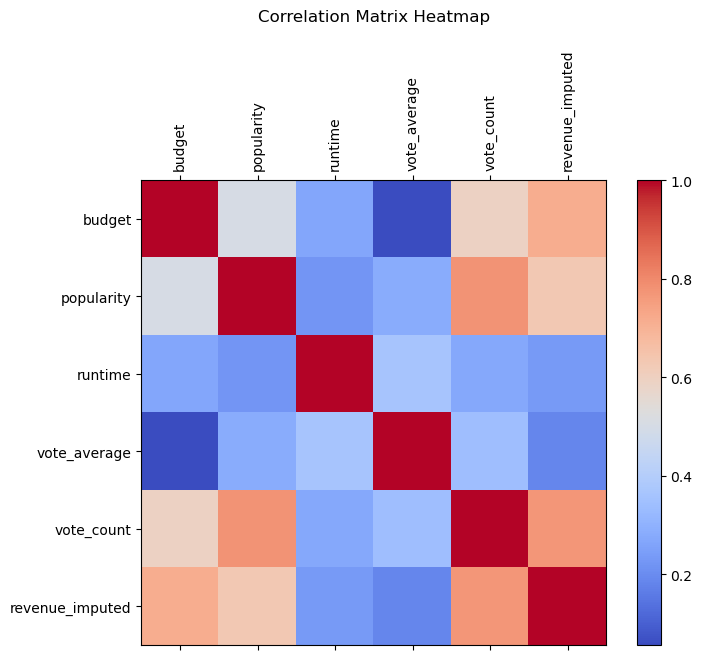

In [43]:
# Corr matrix as heatmap
plt.figure(figsize = (8, 6))
cax = plt.matshow(corr_matrix, fignum = 1, cmap = 'coolwarm')
plt.colorbar(cax)
plt.xticks(range(len(numerical_vars)), numerical_vars, rotation = 90)
plt.yticks(range(len(numerical_vars)), numerical_vars)
plt.title("Correlation Matrix Heatmap", pad = 20)
plt.show()

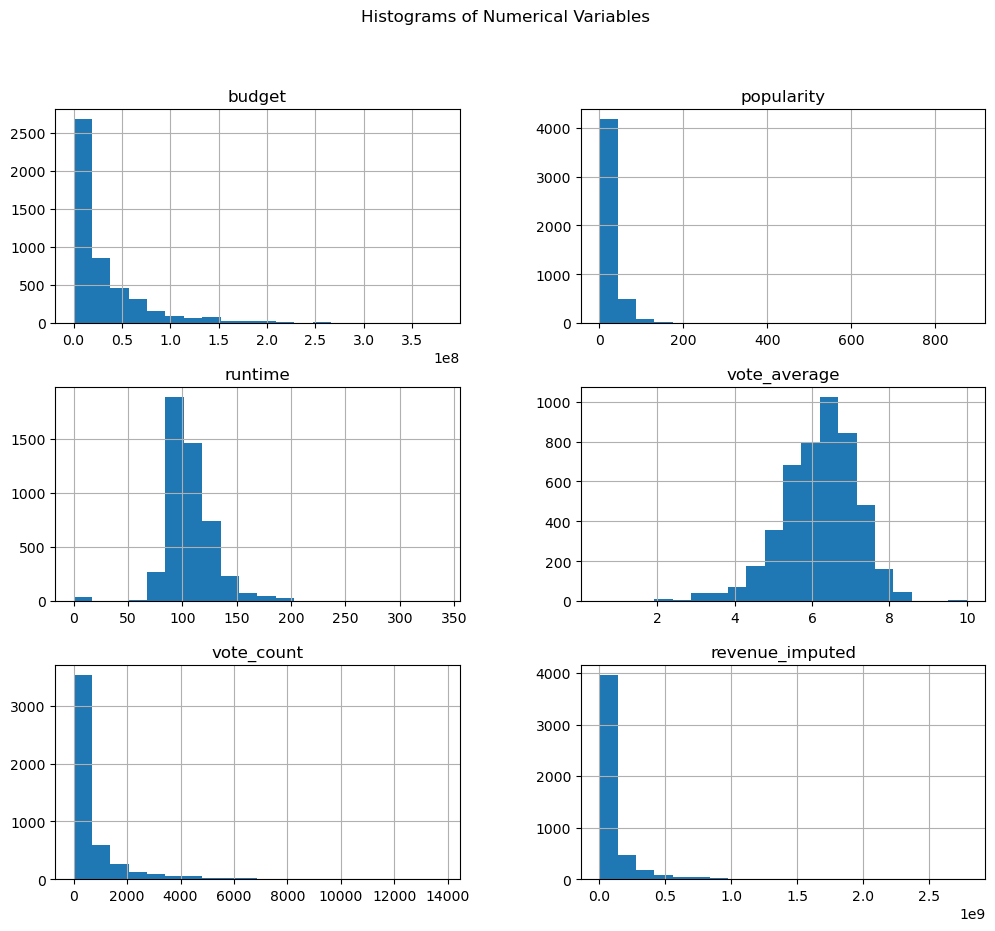

In [44]:
# Histograms
movies[numerical_vars].hist(bins = 20, figsize = (12, 10))
plt.suptitle("Histograms of Numerical Variables")
plt.show()

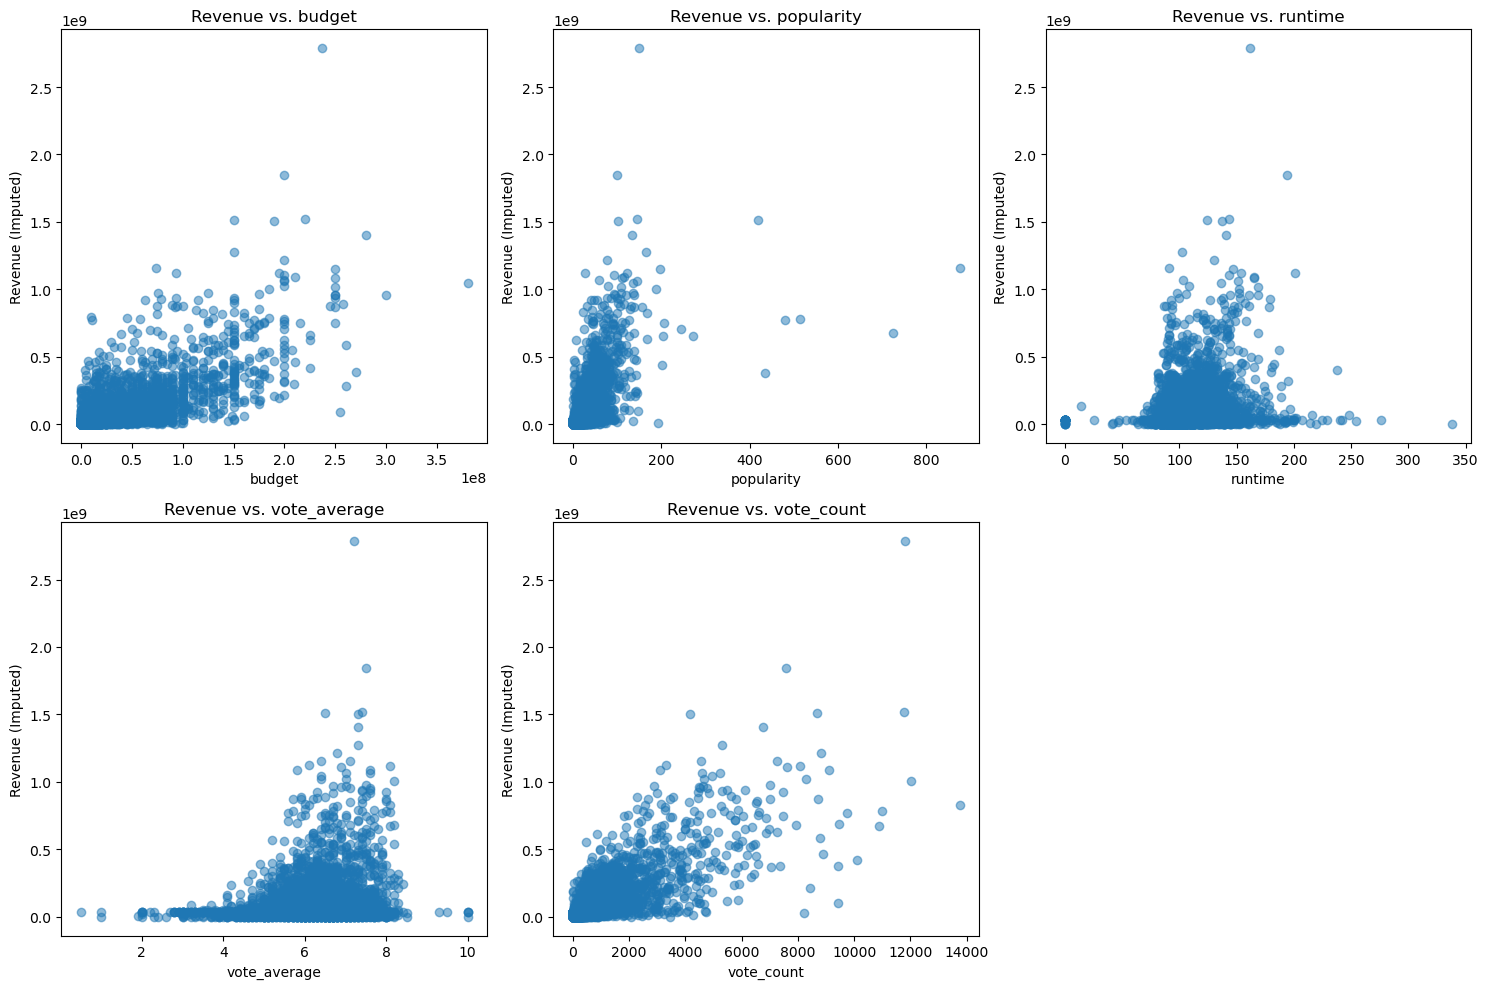

In [45]:
# Scatter plots: Revenue vs. other features
features = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']
plt.figure(figsize = (15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    plt.scatter(movies[feature], movies['revenue_imputed'], alpha = 0.5)
    plt.xlabel(feature)
    plt.ylabel('Revenue (Imputed)')
    plt.title(f'Revenue vs. {feature}')
plt.tight_layout()
plt.show()

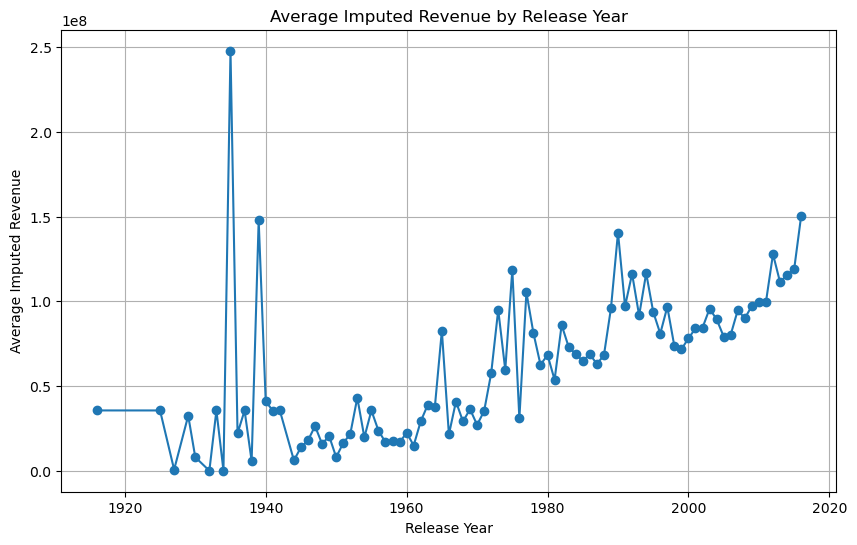

In [46]:
# Time series analysis: average Revenue by release year
avg_revenue_year = movies.groupby('release_year')['revenue_imputed'].mean()
plt.figure(figsize = (10, 6))
plt.plot(avg_revenue_year.index, avg_revenue_year.values, marker = 'o')
plt.xlabel("Release Year")
plt.ylabel("Average Imputed Revenue")
plt.title("Average Imputed Revenue by Release Year")
plt.grid(True)
plt.show()

## Categorical Variables

In [48]:
# Helper function to count frequency of categories in a column
def count_categories(series):
    counter = Counter()
    # Drop missing values, split each entry by comma and update the counter
    for entry in series.dropna():
        categories = [cat.strip() for cat in entry.split(",") if cat.strip()]
        counter.update(categories)
    return counter

Genre Counts:
Drama              2296
Comedy             1721
Thriller           1274
Action             1154
Romance             894
Adventure           790
Crime               696
Science Fiction     535
Horror              519
Family              512
Fantasy             424
Mystery             348
Animation           234
History             197
Music               185
War                 144
Documentary         110
Western              82
Foreign              34
TV Movie              8
dtype: int64


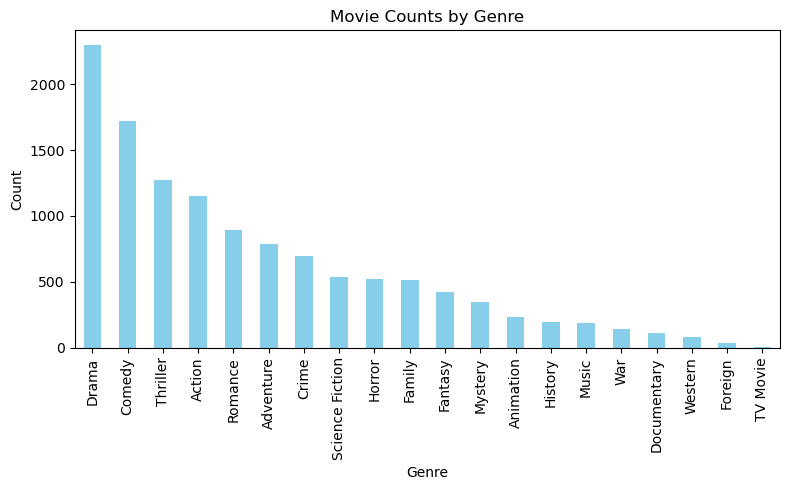

In [49]:
# genres
genre_counts = count_categories(movies['genres'])
# Convert to a pandas Series for easier plotting and sorting
genre_counts_series = pd.Series(genre_counts).sort_values(ascending = False)
print("Genre Counts:")
print(genre_counts_series)

plt.figure(figsize = (8, 5))
genre_counts_series.plot(kind = 'bar', color = 'skyblue')
plt.title("Movie Counts by Genre")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Top 10 Production Companies:
Warner Bros.                              319
Universal Pictures                        311
Paramount Pictures                        285
Twentieth Century Fox Film Corporation    222
Columbia Pictures                         201
New Line Cinema                           165
Metro-Goldwyn-Mayer (MGM)                 122
Touchstone Pictures                       118
Walt Disney Pictures                      114
Relativity Media                          102
dtype: int64


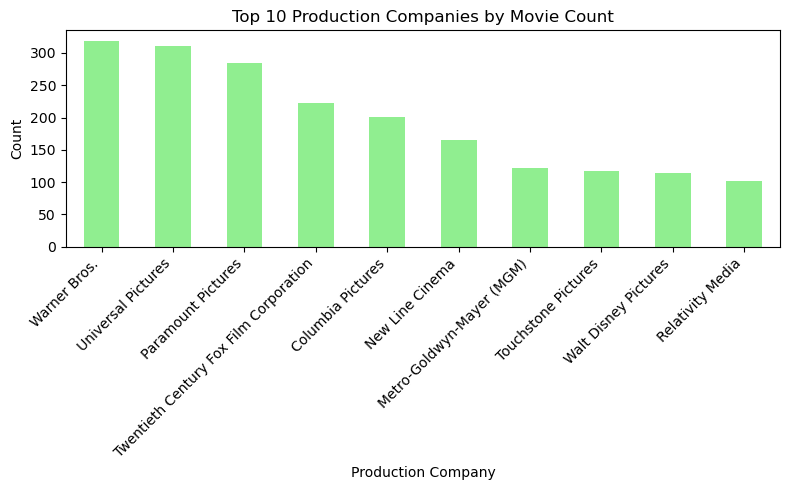

In [50]:
# production_companies
prod_company_counts = count_categories(movies['production_companies'])
prod_company_series = pd.Series(prod_company_counts).sort_values(ascending = False)
print("Top 10 Production Companies:")
print(prod_company_series.head(10))

plt.figure(figsize = (8, 5))
prod_company_series.head(10).plot(kind = 'bar', color = 'lightgreen')
plt.title("Top 10 Production Companies by Movie Count")
plt.xlabel("Production Company")
plt.ylabel("Count")
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

Production Country ISO Counts (Top 10):
US    3956
GB     636
DE     324
FR     306
CA     261
AU     110
IT      72
ES      71
CN      59
JP      58
dtype: int64


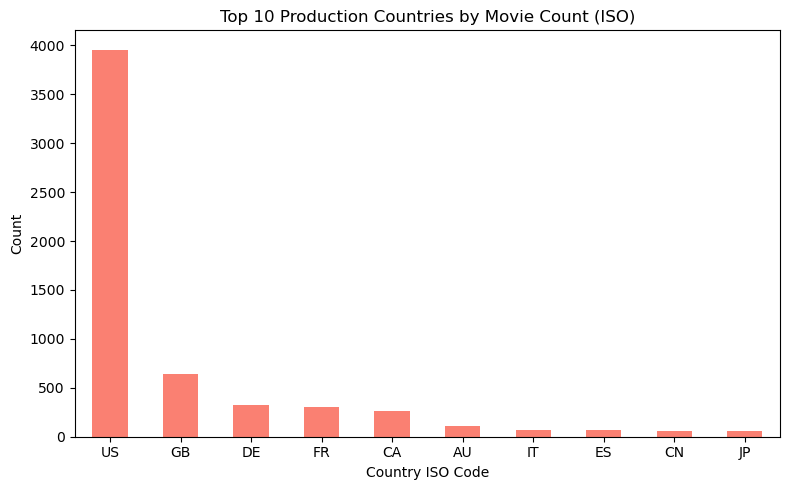

In [51]:
# 3. Analysis for 'production_ISO'
prod_ISO_counts = count_categories(movies['production_ISO'])
prod_ISO_series = pd.Series(prod_ISO_counts).sort_values(ascending = False)
print("Production Country ISO Counts (Top 10):")
print(prod_ISO_series.head(10))

plt.figure(figsize = (8, 5))
prod_ISO_series.head(10).plot(kind = 'bar', color = 'salmon')
plt.title("Top 10 Production Countries by Movie Count (ISO)")
plt.xlabel("Country ISO Code")
plt.ylabel("Count")
plt.xticks(rotation = 0, ha = 'center')
plt.tight_layout()
plt.show()

Spoken Language ISO Counts (Top 10):
en    4484
fr     437
es     351
de     262
it     188
ru     185
zh     155
ja      97
pt      68
ar      67
dtype: int64


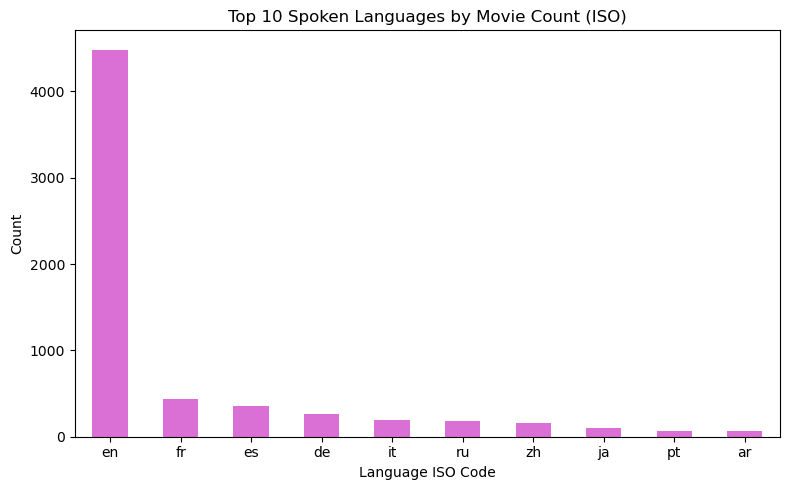

In [52]:
# spoken_ISO
spoken_ISO_counts = count_categories(movies['spoken_ISO'])
spoken_ISO_series = pd.Series(spoken_ISO_counts).sort_values(ascending = False)
print("Spoken Language ISO Counts (Top 10):")
print(spoken_ISO_series.head(10))

plt.figure(figsize = (8, 5))
spoken_ISO_series.head(10).plot(kind = 'bar', color = 'orchid')
plt.title("Top 10 Spoken Languages by Movie Count (ISO)")
plt.xlabel("Language ISO Code")
plt.ylabel("Count")
plt.xticks(rotation = 0, ha = 'center')
plt.tight_layout()
plt.show()

Movies Released per Year:
release_year
1916.0      1
1925.0      1
1927.0      1
1929.0      2
1930.0      1
         ... 
2012.0    208
2013.0    231
2014.0    238
2015.0    216
2016.0    104
Name: count, Length: 89, dtype: int64


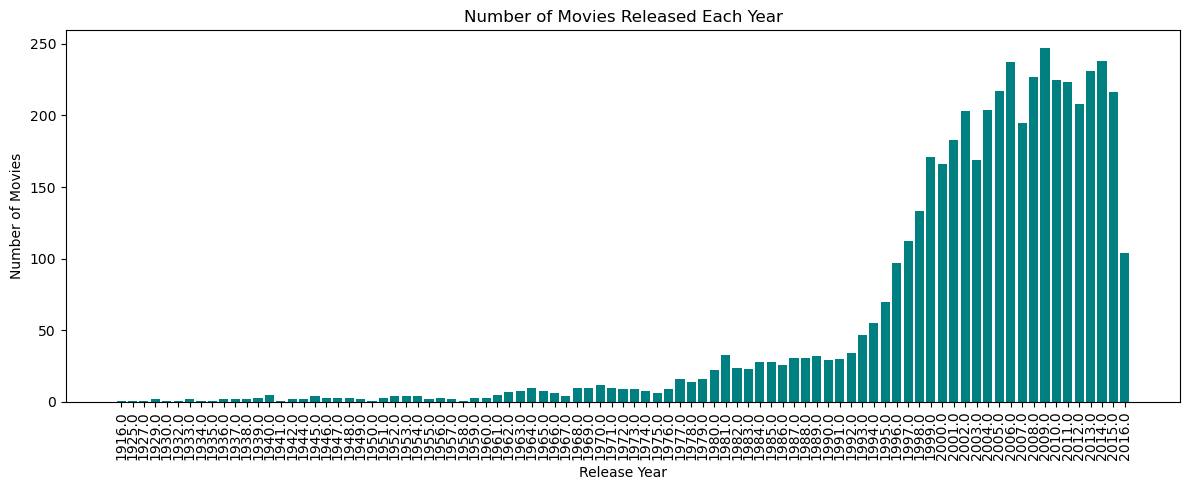

In [53]:
# movies released per year
release_year_counts = movies['release_year'].value_counts().sort_index()
print("Movies Released per Year:")
print(release_year_counts)

plt.figure(figsize = (12, 5))
plt.bar(release_year_counts.index.astype(str), release_year_counts.values, color = 'teal')
plt.xlabel("Release Year")
plt.ylabel("Number of Movies")
plt.title("Number of Movies Released Each Year")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

In [54]:
movies.to_csv("clean_movie_data.csv", index = False)